In [1]:
import os
import pandas as pd 
import numpy as np 
import subprocess
import math
import matplotlib.pyplot as plt 
from matplotlib.patches import Patch 
plt.rcParams['font.family'] = 'Arial'

from selenobot.files import FASTAFile, fasta_file_parser_gtdb, GBFFFile, BLASTFile
from selenobot.tools import BLAST
from selenobot.genes import Gene, Genome

model_organisms = dict()
model_organisms['Pseudomonas aeruginosa'] = 'paer'
model_organisms['Escherichia coli'] = 'ecol'
model_organisms['Mycobacterium tuberculosis'] = 'mtub' 
model_organisms['Bacillus subtilis'] = 'bsub'
model_organisms['Aliivibrio fischeri'] = 'afis'

%load_ext autoreload 
%autoreload 2

In [2]:
genome_metadata_df = pd.read_csv('../data/gtdb_genome_metadata_bacteria.csv', index_col=0)
genome_metadata_df = genome_metadata_df[genome_metadata_df.species.isin(model_organisms.keys())]
genome_metadata_df['code_name'] = genome_metadata_df.species.replace(model_organisms)

In [3]:
for species, code_name in model_organisms.items():
    metadata_df = FASTAFile(f'../data/model_organisms/gtdb_{code_name}_protein.faa').to_df(parser=fasta_file_parser_gtdb)
    metadata_df = pd.concat([metadata_df, genome_metadata_df[genome_metadata_df.code_name == code_name]], axis=1)
    metadata_df = metadata_df.bfill()
    metadata_df.index.name = 'id'
    metadata_df.to_csv(f'../data/model_organisms/gtdb_{code_name}_metadata.csv')

In [4]:
def download_ncbi_data():
    
    genome_ids, code_names = list(genome_metadata_df.index), list(genome_metadata_df.code_name)

    cmd = 'datasets download genome accession {genome_ids} --filename ../data/model_organisms/ncbi.zip --include protein,gbff,genome'.format(genome_ids=' '.join(genome_ids))
    # subprocess.run(cmd, shell=True, check=True)
    # subprocess.run('unzip ../data/model_organisms/ncbi.zip', shell=True, check=True)
        
    for code_name, genome_id in zip(code_names, genome_ids):
        subprocess.run(f'cp ../data/model_organisms/ncbi/ncbi_dataset/data/{genome_id}/protein.faa ../data/model_organisms/ncbi_{code_name}_protein.faa', shell=True, check=True)
        subprocess.run(f'cp ../data/model_organisms/ncbi/ncbi_dataset/data/{genome_id}/genomic.gbff ../data/model_organisms/ncbi_{code_name}_genomic.gbff', shell=True, check=True)
        subprocess.run(f'cp ../data/model_organisms/ncbi/ncbi_dataset/data/{genome_id}/*_genomic.fna ../data/model_organisms/ncbi_{code_name}_genomic.fna', shell=True, check=True)


def run_blast():

    blast = BLAST()

    for species, code_name in model_organisms.items():
        query_path = f'../data/model_organisms/gtdb_{code_name}_protein.faa'
        subject_path = f'../data/model_organisms/ncbi_{code_name}_protein.faa'
        output_path = f'../data/model_organisms/gtdb_{code_name}_protein.blast.tsv'
        if not os.path.exists(output_path):
            print(f'Running BLAST for {species}')
            blast.run(query_path, subject_path, output_path=output_path, max_high_scoring_pairs=1, max_subject_sequences=1, make_database=False)

download_ncbi_data()

In [5]:
species, code_name = 'Escherichia coli', 'ecol'
species, code_name = 'Mycobacterium tuberculosis', 'mtub'
species, code_name = 'Pseudomonas aeruginosa', 'paer'

blast_df = BLASTFile(f'../data/model_organisms/gtdb_{code_name}_protein.blast.tsv', max_e_value=10).to_df()
    
gbff_cols = ['start', 'stop', 'protein_id', 'strand', 'note', 'product', 'gene'] # , 'go_function', 'go_process', 'go_component', 'ec_number']
gbff_df = GBFFFile(f'../data/model_organisms/ncbi_{code_name}_genomic.gbff').to_df()[gbff_cols].rename(columns={col:f'subject_{col}' for col in gbff_cols})

predictions_df = pd.read_csv(f'../data/results/gtdb_{code_name}.predict.csv', index_col=0)

results_df = blast_df.merge(gbff_df, left_on='subject_id', right_on='subject_protein_id', how='left')
results_df.index = blast_df.index
results_df = predictions_df.merge(results_df, left_index=True, right_index=True, how='outer')

BLASTFile.load: Loaded 5787 out of 5787 entries which met the E-value threshold <= 10.000.
GBFFFile.__init__: Found 5785 coding sequences in the GBFF file.


GBFFFile.__init__: Parsing GBFF file entries.: 100%|██████████| 5785/5785 [00:00<00:00, 10054.19it/s]

GBFFFile.__init__: Removing 119 entries with no protein ID.
GBFFFile.remove_duplicates: Removing 9 duplicate entries from the GBFF file.


## Binary model results

In [6]:
# NOTE: Should I incorporate E-value thresholds? If so, what should I use?
# NOTE: Why are there some sequences which are nearly exact matches, but are on opposite strands?

def blast_possible_match(row) -> bool:
    '''Determine a BLAST hit with a high E-value (i.e. not a very good one) might be a match using the following criteria:
    (1)
    (2)
    (3)
    The reason I did not make sure that non-adjusted sequence identity was close to 100 is I thought there might be weird 
    frame-shift stuff happening if gene boundaries are mis-indentified.
    '''
    query_start, query_stop, query_strand = row.start, row.stop, row.strand
    subject_start, subject_stop, subject_strand = row.subject_start, row.subject_stop, row.subject_strand
    
    # There are NaNs if there was no BLAST hit at all.
    if np.any(np.isnan([query_start, query_stop, subject_start, subject_stop])):
        return False

    if query_strand != subject_strand:
        return False
    
    margin = 50 # Is this a reasonable margin? 
    subject_range = range(int(subject_start - margin), int(subject_stop + margin))
    query_range = range(int(query_start - margin), int(query_stop + margin))

    checks = [query_start in subject_range, query_stop in subject_range]
    checks += [subject_start in query_range, subject_stop in query_range]
    return np.any(checks)


def blast_exact_match(row) -> bool:
    '''Determine a BLAST hit between the query and subject is the same protein:
    (1)
    (2)
    (3)
    '''
    query_length, subject_length = row.query_sequence_length, row.subject_sequence_length

    length_margin = 2
    identity_threshold = 1 - (length_margin / max(query_length, subject_length))

    checks = [math.isclose(row.subject_sequence_length, row.query_sequence_length, abs_tol=length_margin)]
    checks += [row.adjusted_sequence_identity >= identity_threshold]
    checks += [row.strand == row.subject_strand]
    return np.all(checks)
    
results_df['blast_possible_match'] = results_df.apply(blast_possible_match, axis=1)
results_df['blast_exact_match'] = results_df.apply(blast_exact_match, axis=1)

In [7]:
print(species, end='\n\n')

ncbi_fasta_file = FASTAFile(f'../data/model_organisms/ncbi_{code_name}_protein.faa')
results_1_df = results_df[results_df.binary_model_plm_prediction == 1]
results_0_df = results_df[results_df.binary_model_plm_prediction == 0]

print('Number of proteins:', len(results_df), 'versus NCBI:', len(ncbi_fasta_file))
print('Number of predicted selenoproteins:', len(results_1_df), end='\n\n')

print(f'Percentage of proteins with BLAST hits: {100 * (~results_df.subject_id.isnull()).sum() / len(results_df):.2f}%')
print(f'Percentage of predicted selenoproteins with BLAST hits: {100 * (~results_1_df.subject_id.isnull()).sum() / len(results_1_df):.2f}%', end='\n\n')

print(f'Percentage of proteins with exact BLAST hits: {100 * results_df.blast_exact_match.sum() / len(results_df):.2f}%')
print(f'Percentage of predicted full-length with exact BLAST hits: {100 * results_0_df.blast_exact_match.sum() / len(results_0_df):.2f}%')
print(f'Percentage of predicted selenoproteins with exact BLAST hits: {100 * results_1_df.blast_exact_match.sum() / len(results_1_df):.2f}%', end='\n\n')

# The predicted selenoproteins with exact BLAST hits and are annotated with a function seem likely to be false positives. 
# The predicted selenoproteins with no possible BLAST hits seem likely to be Prodigal errors (but maybe not?). 
# The predicted selenoproteins with possible BLAST hits are promising (in E. coli, the formate dehydrogenase subunits are included in this)
# It also seems potentially worth looking into the predicted selenoproteins with no annotation. For E. coli, none of these showed up with PaperBLAST. 

# Honestly, I might just try extending all of them to see what happens. 

Pseudomonas aeruginosa

Number of proteins: 5788 versus NCBI: 5657
Number of predicted selenoproteins: 37

Percentage of proteins with BLAST hits: 99.98%
Percentage of predicted selenoproteins with BLAST hits: 100.00%

Percentage of proteins with exact BLAST hits: 90.74%
Percentage of predicted full-length with exact BLAST hits: 91.08%
Percentage of predicted selenoproteins with exact BLAST hits: 37.84%



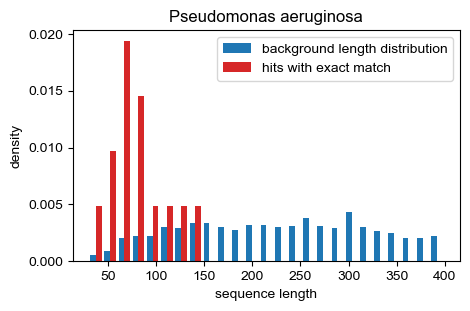

In [8]:
# The predicted selenoproteins with exact BLAST hits are likely the false-positives. Let's take a closer look at those... 

fig, ax = plt.subplots(figsize=(5, 3))

max_length = 400 

all_lengths = results_df.seq.apply(len)
fp_lengths = results_1_df[results_1_df.blast_exact_match].seq.apply(len)

colors = ['tab:blue', 'tab:red']
ax.hist((all_lengths[all_lengths < max_length], fp_lengths[all_lengths < max_length]), color=colors, density=True, bins=25)
ax.legend(['background length distribution', 'hits with exact match'])
ax.set_title(species)
ax.set_ylabel('density')
ax.set_xlabel('sequence length')

# NOTE: An ECDF might be a better way of showing this. 
plt.show()

In [9]:
genome = Genome(f'../data/model_organisms/ncbi_{code_name}_genomic.fna')

extended_df = []
for row in results_1_df.itertuples():
    gene = Gene(row.Index, genome, start=int(row.start) - 1, stop=int(row.stop), strand=row.strand)
    gene = gene.extend()
    extended_df.append(gene.info())
extended_df = pd.DataFrame(extended_df).set_index('gene_id')

FASTAFile.from_df(extended_df).write(f'../data/model_organisms/gtdb_{code_name}_protein.extend.faa')

blast = BLAST()
query_path = f'../data/model_organisms/gtdb_{code_name}_protein.extend.faa'
subject_path = f'../data/model_organisms/ncbi_{code_name}_protein.faa'
output_path = f'../data/model_organisms/gtdb_{code_name}_protein.extend.blast.tsv'
blast.run(query_path, subject_path, output_path=output_path, max_high_scoring_pairs=1, max_subject_sequences=1, make_database=False)

'../data/model_organisms/gtdb_paer_protein.extend.blast.tsv'

In [10]:
metadata_df = pd.read_csv(f'../data/model_organisms/gtdb_{code_name}_metadata.csv', dtype={'partial':str}, index_col=0)

extended_blast_df = BLASTFile(f'../data/model_organisms/gtdb_{code_name}_protein.extend.blast.tsv', max_e_value=10).to_df()
extended_results_df = extended_blast_df.merge(gbff_df, left_on='subject_id', right_on='subject_protein_id', how='left')
extended_results_df.index = extended_blast_df.index
extended_results_df = extended_results_df.merge(metadata_df, left_index=True, right_index=True, how='left')
extended_results_df = extended_results_df.merge(extended_df[['extension_size', 'original_stop_codon', 'stop_codon', 'start_codon']], left_index=True, right_index=True, how='left')

extended_results_df['blast_possible_match'] = extended_results_df.apply(blast_possible_match, axis=1)
extended_results_df['blast_exact_match'] = extended_results_df.apply(blast_exact_match, axis=1)

print(f'Percentage of extended proteins with exact BLAST hits: {100 * extended_results_df.blast_exact_match.sum() / len(extended_results_df):.2f}%')


BLASTFile.load: Loaded 37 out of 37 entries which met the E-value threshold <= 10.000.
Percentage of extended proteins with exact BLAST hits: 2.70%


In [12]:
extended_results_df[extended_results_df.blast_exact_match][['subject_product', 'extension_size']]

,subject_product,extension_size
id,,
NZ_LN831024.1_5007,formate dehydrogenase-N subunit alpha,2490
